## Depression Identification Simulation

Note: The features are generated using PCA.ipynb.

In [1]:
import pandas as pd
import numpy as np

df_feats = pd.read_csv('reduced_data.csv')
df_labels = pd.read_csv('disorders.csv')['Depressed']

## 1. State assumptions about your data

- X has size: n samples by m features.

- X are i.i.d. random variables.

- X_j (j = 1,...,m) are identically distributed.

## 2. Formally define classification problem

Feature matrix X: R<sup>n x m</sup>

Each sample X<sub>i</sub> ∈ R<sup>m</sup>, i ∈ [1, n]

Label y<sub>i</sub> ∈ {0, 1}, i ∈ [1, n]

g(X) → y

G := { g: R → {0, 1} }

Goal: g<sup>*</sup> = argmin<sub>g ∈ G</sub> E[L(g(X), y)], where L denotes loss function.


The loss function L differs for different classifiers and is speficied in the classfication context below:

- Multinomial Naive Bayes: negative joint likelihood

    - L = -log p(X, y)
    
    
- Logistic Regression:  logistic loss (cross-entropy loss)

    - L = -log P(y|g(X)) = -(y · log(g(X)) + (1 - y) · log(1 - g(X))


- K Nearest Neighbors

    - L = ∑<sub>i</sub> D(X<sub>i</sub>|y<sub>i</sub>=1, X|y=1) + ∑<sub>i</sub> D(X<sub>i</sub>|y<sub>i</sub>=0, X|y=0)
    
    - D(a, b) = (a - b)<sup>2</sup>


- Support Vector Machine: squared hinge loss

    - L = (max{0, 1 − y · g(x)})<sup>2</sup>


- Random Forest

    - L = ∑<sub>i</sub> (g(X<sub>i</sub>) - y<sub>i</sub>)<sup>2</sup>
    
    
- Quadratic Discriminant Analysis

    - L = max{0, 1 − y · g(x)}

## 3. Provide algorithm for solving problem (including choosing hyperparameters as appropriate)

    
- Logistic Regression

    - penalty = 'l1' (l1 norm for penalization)


- K Nearest Neighbors

    - n_neighbors = 7


- Support Vector Machine (Linear Kernel)
    
    - C: default = 1.0 (penalty parameter of the error term)
    

- Random Forest
    
    - n_estimators = 20 (number of trees)
    
    - criterion: default = 'gini'


- Quadratic Discriminant Analysis

    - None

#### Note: Generate random samples and plot accuracies based on Greg's code.

### Simulation Setup

In [2]:
np.random.seed(12345678) # for reproducibility, set random seed
r = 27  # define number of rois
N = 100 # number of samples at each iteration
p0 = 0.10
p1 = 0.15

# define number of subjects per class
S = np.array((8, 16, 20, 32, 40, 64, 80, 100, 120, 200, 320, 400, 800, 1000))

### Training & Test Utilities

In [3]:
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut

# Train the given classifier
def train_clf(clf, train_feats, train_labels):
    # Supervised training
    clf.fit(train_feats, train_labels)
    
# Test the given classifier anc calculate accuracy
def test_clf(clf, test_feats, test_labels):
    # Predict using test set
    predicted = clf.predict(test_feats)
    # Compute accuracy
    acc = np.mean(predicted == test_labels)
    return predicted, acc

# Compute accuracy of a model trained with a specific number (n) of samples 
def compute_acc(clf, n):
    train_clf(clf, train_X[:n], train_y[:n])
    predict_y, acc = test_clf(clf, test_X, test_y)
    return acc

# Leave one out cross validation
def loo_cv(clf, X, y):
    loo = LeaveOneOut(len(X))
    scores = cross_validation.cross_val_score(clf, X, y, cv=loo)
    return scores.mean(), scores.std()

## 4 & 5. Sample data from a simulation setting & Compute Accuracy 

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.qda import QDA

[acc_LG, acc_KNN, acc_SVM, acc_RF, acc_QDA] = [[]  for i in xrange(5)] 
[err_LG, err_KNN, err_SVM, err_RF, err_QDA] = [[]  for i in xrange(5)] # accuracy standard deviation

for idx1, s in enumerate(S):
    s0=s/2
    s1=s/2

    g0 = 1 * (np.random.rand(r, r, s0) > 1-p0)
    g1 = 1 * (np.random.rand(r, r, s1) > 1-p1)
    mbar0 = 1.0 * np.sum(g0, axis=(0,1))
    mbar1 = 1.0 * np.sum(g1, axis=(0,1))

    X = np.array((np.append(mbar0, mbar1), np.append(mbar0/(r**2), mbar1/(r**2)))).T
    y = np.append(np.zeros(s0), np.ones(s1))
    
    # Split the simulated data into training set and test set
    # Randomly sample 20% data as the test set
    train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Logistic Regression
    lg = LogisticRegression(penalty='l1')
    acc, acc_std = loo_cv(lg, X, y)
    acc_LG.append(acc)
    err_LG.append(acc_std)

    # K Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=7)
    acc, acc_std = loo_cv(knn, X, y)
    acc_KNN.append(acc)
    err_KNN.append(acc_std)

    # Support Vector Machine
    svc = LinearSVC()
    acc, acc_std = loo_cv(svc, X, y)
    acc_SVM.append(acc)
    err_SVM.append(acc_std) 

    # Random Forest
    rf = RandomForestClassifier(n_estimators=20) 
    acc, acc_std = loo_cv(rf, X, y)
    acc_RF.append(acc)
    err_RF.append(acc_std) 

    # Quadratic Discriminant Analysis
    qda = QDA()
    acc, acc_std = loo_cv(qda, X, y)
    acc_QDA.append(acc)
    err_QDA.append(acc_std)

/Library/Python/2.7/site-packages/sklearn/qda.py:124: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## 6. Plot accuracy vs. sample size in simulation

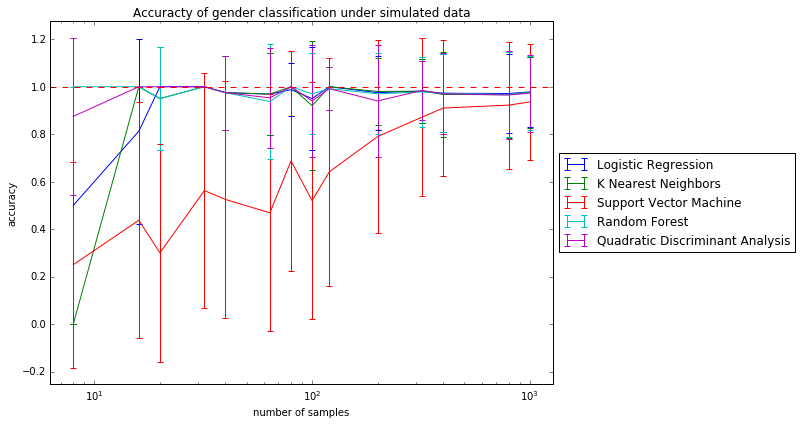

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(1)
fig.set_size_inches(9, 6.5)

plt.errorbar(S, acc_LG, yerr=err_LG, label='Logistic Regression')
plt.errorbar(S, acc_KNN, yerr=err_KNN, label='K Nearest Neighbors')
plt.errorbar(S, acc_SVM, yerr=err_SVM, label='Support Vector Machine')
plt.errorbar(S, acc_RF, yerr=err_RF, label='Random Forest')
plt.errorbar(S, acc_QDA, yerr=err_QDA, label='Quadratic Discriminant Analysis')

plt.xscale('log')
plt.xlabel('number of samples')
plt.ylabel('accuracy')
plt.title('Accuracty of gender classification under simulated data')
plt.axhline(1, color='red', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 7. Apply method directly on real data

In [6]:
# Not needed in this notebook, only used in an ealier verion, kept in case
def clean_negs(X):
    # Get indices of columns that contain negative values
    neg_col_inds = np.unique(np.where(X<0)[1])
    # Subtract minimum negative for each column
    for neg_i in neg_col_inds:
        neg_col = X[:, neg_i]
        min_neg = np.min(neg_col)
        new_col = [c - min_neg for c in neg_col] 
        X[:, neg_i] = new_col
    return X

In [7]:
'''
Data Preparation
'''
from sklearn.cross_validation import train_test_split

real_X = df_feats.get_values()
real_y = df_labels.get_values()

print 'Dataset size is', real_X.shape

Dataset size is (2796, 27)


In [8]:
# Logistic Regression
lg = LogisticRegression(penalty='l1')
acc_lg, acc_std_lg = loo_cv(lg, real_X, real_y)

# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=7)
acc_knn, acc_std_knn = loo_cv(knn, real_X, real_y)

# Support Vector Machine
svc = LinearSVC()
acc_svm, acc_std_svm = loo_cv(svc, real_X, real_y)

# Random Forest
rf = RandomForestClassifier(n_estimators=20) 
acc_rf, acc_std_rf = loo_cv(rf, real_X, real_y) 

# Quadratic Discriminant Analysis
qda = QDA()
acc_qda, acc_std_qda = loo_cv(qda, real_X, real_y)

In [9]:
print 'Logistic Regression accuracy is %0.4f (+/- %0.3f)' % (acc_lg, acc_std_lg)
print 'K Nearest Neighbors accuracy is %0.4f (+/- %0.3f)' % (acc_knn, acc_std_knn)
print 'Support Vector Machine (Linear Kernel) accuracy is %0.4f (+/- %0.3f)' % (acc_svm, acc_std_svm)
print 'Random Forest accuracy is %0.4f (+/- %0.3f)' % (acc_rf, acc_std_rf)
print 'Quadratic Discriminant Analysis accuracy is %0.4f (+/- %0.3f)' % (acc_qda, acc_std_qda)

Logistic Regression accuracy is 0.9653 (+/- 0.183)
K Nearest Neighbors accuracy is 0.5594 (+/- 0.496)
Support Vector Machine (Linear Kernel) accuracy is 0.4882 (+/- 0.500)
Random Forest accuracy is 0.9649 (+/- 0.184)
Quadratic Discriminant Analysis accuracy is 0.9624 (+/- 0.190)


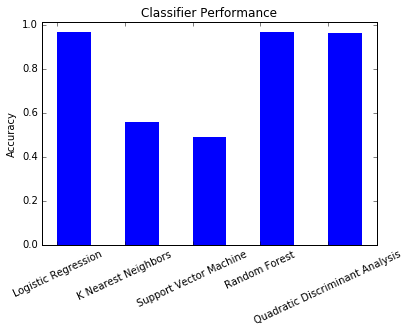

In [10]:
# Visualize classifier performance
x = range(5)
y = [acc_lg, acc_knn, acc_svm, acc_rf, acc_qda]
clf_names = ['Logistic Regression', 'K Nearest Neighbors', \
             'Support Vector Machine', 'Random Forest', 'Quadratic Discriminant Analysis']

width = 0.6/1.2
plt.bar(x, y, width)

plt.title('Classifier Performance')
plt.xticks(x, clf_names, rotation=25)
plt.ylabel('Accuracy')

## 8. Explain the degree to which you believe the result and why

The best classification accuracy on the test set is about 96.53%, yielded by the logistic regression classifier. Random forest and quadratic discriminant analysis classifier also give satisfying results on our real data.

Logistic regression is intuitively simple while reasonably complex compared to some other naive or linear models (e.g. naive bayes and linear regression). It is also prune to overfitting. 

KNN computes distances between samples to determine which class a sample belongs to. It does not capture the importance of each feature. It is simple and elegant but not semantically powerful enough. From the result of KNN we can conclude that we should not use a non-parametric method to analyze our data.

Random forest deals well with skewed data, but it can overfit the training data. If we can remove more noise from the training data, theoretically random forest would perform even better.

Note that for this notebook, we preprocessed features using PCA and Sparse PCA, to eliminate the dimensionality curse for SVM, but its performance is still intolerable. This is because our data might be skewed, since it contains so much information, and can be divided into subsets and trained in parallel (e.g. individual information, disorder diagnosis, questionare data, RBF data), SVM is inefficient in such senario.

QDA has quadratic decision boundary and works very well on small dataset. But it might not be ideal for larger and noiser dataset, since its non-linearity leads to complexity in many senses. 

Next Steps:
 - Think about our assumptions.
 - Explore other machine learning techniques.
 - Explore other interesting properties of our data.